In [2]:
import uproot
import awkward as ak
import coffea.hist as hist
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
import zfit

#hep.set_style("CMS")

/work/gallim/anaconda3/envs/dask-pyroot-tutorial/lib/python3.7/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [3]:
v0_file = "/work/gallim/root_files/vertex_investigation/VertexInvestigation_vtx0/output_GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8_storeWeights_alesauva-UL2018_0-10_6_4-v0-RunIISummer19UL18MiniAOD-106X_upgrade2018_realistic_v11_L1v1-v1-3f96409841a3cc85b911eb441562baae_USER_*.root"
v_custom_file = "/work/gallim/root_files/vertex_investigation/VertexInvestigation/output_GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8_storeWeights_alesauva-UL2018_0-10_6_4-v0-RunIISummer19UL18MiniAOD-106X_upgrade2018_realistic_v11_L1v1-v1-3f96409841a3cc85b911eb441562baae_USER_*.root"

tree_name = "diphotonDumper/trees/ggH_125_13TeV_All_$SYST"

#variables = ['candidate_id', 'weight', 'mass', 'pt', 'eta', 'leadPt', 'subleadPt', 'rho', 'nvtx', 'event', 'lumi', 'processIndex', 'run', 'npu', 'puweight']

specs = {
    'mass': {
        'bins': 80,
        'range': [100, 140]
    },
    'pt': {
        'bins': 80,
        'range': [0, 300]
    },
    'eta': {
        'bins': 80,
        'range': [-5, 5]
    },
    'leadPt': {
        'bins': 80,
        'range': [0, 300]
    },
    'subleadPt': {
        'bins': 80,
        'range': [0, 200]  
    },
    'rho': {
        'bins': 80,
        'range': [0, 50]
    },
    'vtx_z': {
        'bins': 80,
        'range': [-15, 15]
    },
    'gen_vtx_z': {
        'bins': 80,
        'range': [-15, 15]
    },
    'sigma_m': {
        'bins': 80,
        'range': [0., 0.035]
    },
    'lead_eta': {
        'bins': 80,
        'range': [-3, 3]
    },
    'sublead_eta': {
        'bins': 80,
        'range': [-3, 3]
    }
}
variables = list(specs.keys())

In [3]:
histos = {}

for var, sp in specs.items():
    histos[var] = hist.Hist("Counts", 
                            hist.Cat("vertex", "Vertex"),
                            hist.Bin(var, "${}$".format(var), sp["bins"], *sp["range"])
                           )

In [14]:
%%time

for var, histo in histos.items():
    for batch in uproot.iterate(["{}:{}".format(v_custom_file, tree_name)], expressions=[var, "weight"], library="np"):
        histo.fill(vertex="Vertex Reco", **batch)
    for batch in uproot.iterate(["{}:{}".format(v0_file, tree_name)], expressions=[var, "weight"], library="np"):
        histo.fill(vertex="Vertex 0th", **batch)

CPU times: user 42.6 s, sys: 292 ms, total: 42.9 s
Wall time: 43.1 s


In [4]:
arr = uproot.concatenate(["{}:{}".format(v_custom_file, tree_name)], expressions=['sigma_m'], library='ak')
arr = np.asarray([ev[0] for ev in arr.to_numpy()])

In [32]:
from itertools import combinations
from scipy.optimize import minimize

def get_edges(arr, edge_min, edge_max, n_bins):
    big_num = 99999999
    def compute_total_diff(arr, edge_min, edge_max, *edges_cent):
        edges = [edge_min] + list(edges_cent) + [edge_max]
        try:
            hist, _ = np.histogram(arr, edges)
        except ValueError:
            return big_num
        diff = sum([abs(first - second) for first, second in list(combinations(hist, 2))])
        return diff
    
    n_edges = n_bins + 1
    x0 = np.linspace(edge_min, edge_max, n_edges)
    
    def diff_to_minimize(edges):
            return compute_total_diff(arr, edge_min, edge_max, *edges)
    
    res = minimize(diff_to_minimize, x0=x0[1:-1], method='Powell')
    
    return [edge_min] + list(res.x) + [edge_max]

In [33]:
%%time
edges = get_edges(arr, 0, 0.035, 5)

CPU times: user 52.7 s, sys: 0 ns, total: 52.7 s
Wall time: 52.7 s


In [34]:
edges

[0,
 0.0055277787689635895,
 0.007524089429076878,
 0.009962799507304106,
 0.013287481650168877,
 0.035]

In [35]:
h, _ = np.histogram(arr, edges)

In [36]:
h

array([196524, 196524, 196539, 196539, 196542])

In [11]:
from itertools import product
import multiprocessing

big_num = 9999999999

def compute_total_diff(arr, edge_min, edge_max, edges_cent):
    edges = [edge_min] + list(edges_cent) + [edge_max]
    hist, _ = np.histogram(arr, edges)
    diff = sum([abs(first - second) for first, second in list(combinations(hist, 2))])
    return diff

def compute_total_diff(arr, edge_min, edge_max, edges_cent):
    edges = [edge_min] + list(edges_cent) + [edge_max]
    try:
        hist, _ = np.histogram(arr, edges)
    except:
        return (big_num, *edges_cent)
    diff = sum([abs(first - second) for first, second in list(combinations(hist, 2))])
    return (diff, *edges_cent)

def get_edges(arr, edge_min, edge_max, n_bins):
    n_edges = n_bins + 1
    start_edges = np.linspace(edge_min, edge_max, n_edges)
    big_step = abs(start_edges[0] - start_edges[1])
    small_step = 0.001
    central_edges = start_edges[1:-1]
    ranges = [np.arange(c_edge - big_step, c_edge + big_step, step=small_step) for c_edge in central_edges]
    combinations = list(product(*ranges))
    
    min_diff = big_num
    with multiprocessing.Pool(processes=60) as pool:
        results = pool.starmap(compute_total_diff, [(arr, edge_min, edge_max, comb) for comb in combinations])
    results = np.asarray(results)
    min_row_index = np.where(results == results[:, 0].min())[0]
    best_edges = results[min_row_index, 1:]
    edges = [edge_min] + list(best_edges[0]) + [edge_max]
    '''
    for comb in combinations:
        try:
            diff = compute_total_diff(arr, edge_min, edge_max, *comb)
            if diff < min_diff:
                min_diff = diff
                best_edges = list(comb)
        except:
            pass 
    '''
    return edges

In [ ]:
%%time
edges = get_edges(arr, 0, 0.035, 5)

In [13]:
edges

[0, 0.006, 0.009, 0.014000000000000004, 0.021000000000000005, 0.035]

In [8]:
h, _ = np.histogram(arr, edges)

In [66]:
h

array([258470, 258338, 300526, 144953,  20381])

In [9]:
h

array([350313, 467021, 144953,  18084,   2297])

In [50]:
np.linspace(0, 0.035, 6)

array([0.   , 0.007, 0.014, 0.021, 0.028, 0.035])

In [128]:
np.asarray([[0, 1, 1], [0, 2, 2]])

array([[0, 1, 1],
       [0, 2, 2]])

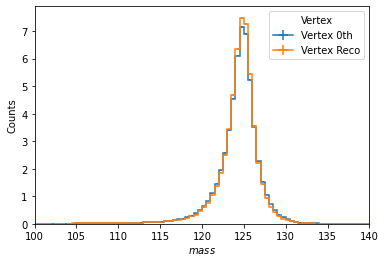

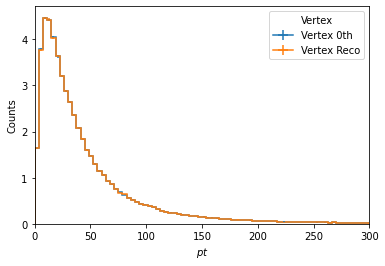

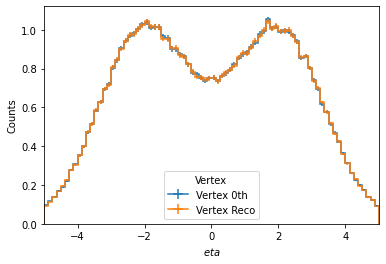

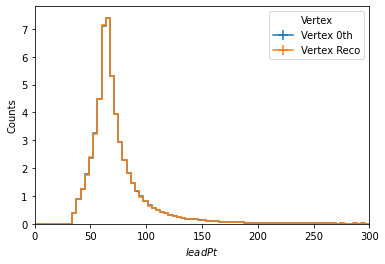

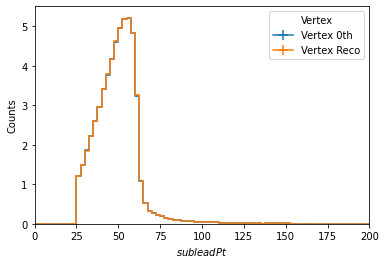

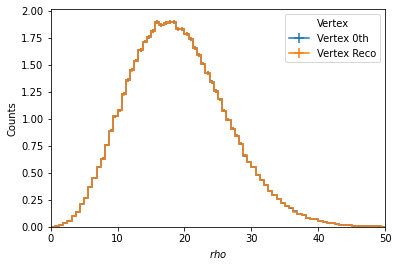

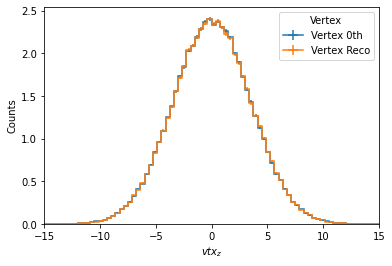

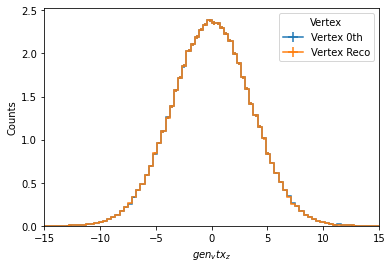

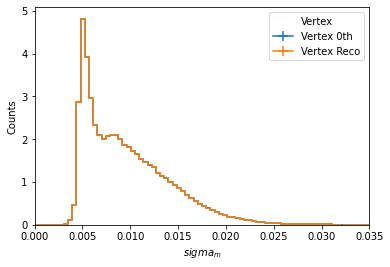

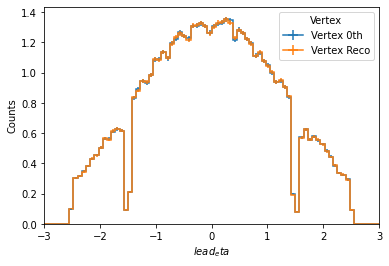

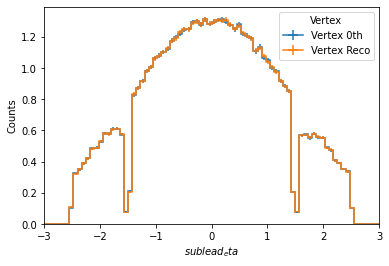

In [5]:
for histo in histos.values():
    fig, ax = plt.subplots()
    hist.plot1d(histo)
    plt.show();

## Useful computations

In [5]:
imp_variables = ["pt", "vtx_z", "gen_vtx_z", "weight", "lead_eta", "sublead_eta", "sigma_m", "mass"]

arr_vtx0 = uproot.lazy(["{}:{}".format(v0_file, tree_name)], imp_variables)
arr_custom = uproot.lazy(["{}:{}".format(v_custom_file, tree_name)], imp_variables)

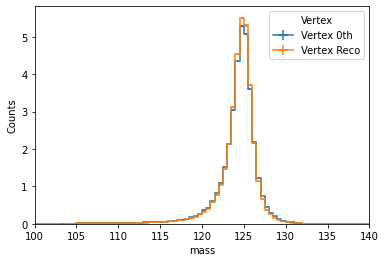

In [6]:
# EB EB

var = 'mass'
arr_vtx0_ebeb = arr_vtx0[np.maximum(abs(arr_vtx0.lead_eta), abs(arr_vtx0.sublead_eta)) < 1.5]
arr_custom_ebeb = arr_custom[np.maximum(abs(arr_custom.lead_eta), abs(arr_custom.sublead_eta)) < 1.5]


histo_eb= hist.Hist("Counts", 
                    hist.Cat("vertex", "Vertex"),
                    hist.Bin(var, "{}".format(var), specs[var]['bins'], *specs[var]['range'])
                    )
histo_eb.fill(vertex="Vertex 0th", mass=arr_vtx0_ebeb[var], weight=arr_vtx0_ebeb["weight"])
histo_eb.fill(vertex="Vertex Reco", mass=arr_custom_ebeb[var], weight=arr_custom_ebeb["weight"])

fig, ax = plt.subplots()
hist.plot1d(histo_eb, density=False)
plt.show();

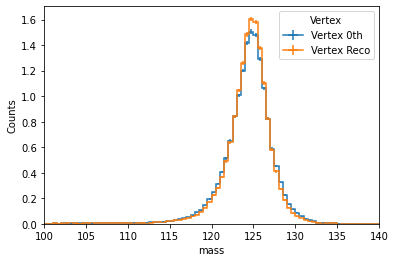

In [7]:
# EB EE

var = 'mass'
arr_vtx0_ebee = arr_vtx0[np.logical_and(
    np.minimum(abs(arr_vtx0.lead_eta), abs(arr_vtx0.sublead_eta)) < 1.5,
    np.maximum(abs(arr_vtx0.lead_eta), abs(arr_vtx0.sublead_eta)) > 1.5
    )]

arr_custom_ebee = arr_custom[np.logical_and(
    np.minimum(abs(arr_custom.lead_eta), abs(arr_custom.sublead_eta)) < 1.5,
    np.maximum(abs(arr_custom.lead_eta), abs(arr_custom.sublead_eta)) > 1.5
    )]

histo_ebee= hist.Hist("Counts", 
                      hist.Cat("vertex", "Vertex"),
                      hist.Bin(var, "{}".format(var), specs[var]['bins'], *specs[var]['range'])
                     )
histo_ebee.fill(vertex="Vertex 0th", mass=arr_vtx0_ebee[var], weight=arr_vtx0_ebee["weight"])
histo_ebee.fill(vertex="Vertex Reco", mass=arr_custom_ebee[var], weight=arr_custom_ebee["weight"])

fig, ax = plt.subplots()
hist.plot1d(histo_ebee, density=False)
plt.show();

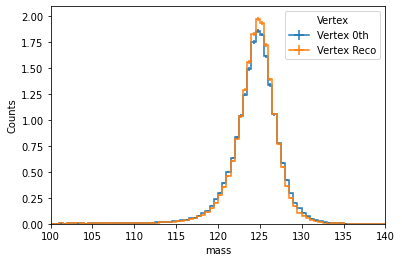

In [8]:
# EE EE

var = 'mass'
arr_vtx0_ee = arr_vtx0[np.maximum(abs(arr_vtx0.lead_eta), abs(arr_vtx0.sublead_eta)) > 1.5]
arr_custom_ee = arr_custom[np.maximum(abs(arr_custom.lead_eta), abs(arr_custom.sublead_eta)) > 1.5]

histo_ee = hist.Hist("Counts", 
                     hist.Cat("vertex", "Vertex"),
                     hist.Bin(var, "{}".format(var), specs[var]['bins'], *specs[var]['range'])
                    )
histo_ee.fill(vertex="Vertex 0th", mass=arr_vtx0_ee[var], weight=arr_vtx0_ee["weight"])
histo_ee.fill(vertex="Vertex Reco", mass=arr_custom_ee[var], weight=arr_custom_ee["weight"])

fig, ax = plt.subplots()
hist.plot1d(histo_ee, density=False)
plt.show();

In [80]:
fit_range = (115, 135)
obs = zfit.Space("M", limits=fit_range)

# Create model
mu = zfit.Parameter("mu", 125, 120, 130)
sigma = zfit.Parameter("sigma", 1, 0.1, 3)
mu_cb = zfit.Parameter("mu_cb", 125, 120, 130)
sigma_cb = zfit.Parameter("sigma_cb", 1, 0.1, 3)
n = zfit.Parameter("n", 1, 0, 5)
alpha = zfit.Parameter("alpha", 1, 0, 20)
frac = zfit.Parameter("frac", 0.5, 0, 1)

gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)
cb = zfit.pdf.CrystalBall(obs=obs, mu=mu_cb, sigma=sigma_cb, n=n, alpha=alpha)

model = zfit.pdf.SumPDF(pdfs=[gauss, cb], fracs=frac)

NameAlreadyTakenError: Another parameter is already named mu. Use a different, unique one.

In [79]:
del obs, mu, sigma, mu_cb, sigma_cb, n, alpha, frac, gauss, cb, model

NameError: name 'mu' is not defined

In [17]:
# Data
data_vtx0_ebee = zfit.Data.from_numpy(obs=obs, array=arr_vtx0_ebee['mass'].to_numpy())
#data_custom_ebee = zfit.Data.from_numpy(obs=obs, array=arr_custom_ebee['mass'].to_numpy())

# build the loss
vtx0_nll = zfit.loss.UnbinnedNLL(model=cb, data=data_vtx0_ebee)
#vtxc_nll = zfit.loss.UnbinnedNLL(model=cb, data=data_custom_ebee)

# minimize
minimizer = zfit.minimize.Minuit()
result_0 = minimizer.minimize(vtx0_nll)
#result_c = minimizer.minimize(vtxc_nll)

# calculate errors
param_errors_0 = result_0.hesse()
#param_errors_c = result_c.hesse()

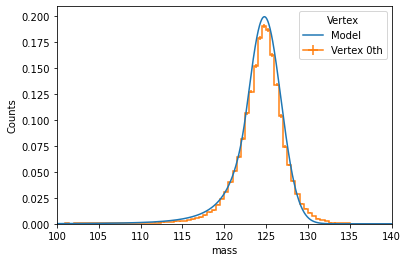

In [22]:
#plot_scaling = data_vtx0_ebee.n_events.numpy() / (len(histo_ebee['Vertex 0th'].axis('mass').edges()) - 1) * obs.area()
#plot_scaling = obs.area() / data_vtx0_ebee.n_events.numpy()
fig, ax = plt.subplots()
x = np.linspace(100, 140, 1000)
#mu.set_value(result_0.params[mu]["value"])
#sigma.set_value(result_0.params[sigma]["value"])
#sigma.set_value(2.5)
#n.set_value(result_0.params[n]["value"])
#alpha.set_value(result_0.params[alpha]["value"])
y = cb.pdf(x, norm_range=fit_range).numpy()
#y2 = cb.pdf(x).numpy()
plt.plot(x, y, label="Model")
#plt.plot(x, y2, label="Model2")
#plt.plot(x, y, label="Model")
hist.plot1d(histo_ebee["Vertex 0th"], density=True)
plt.show();

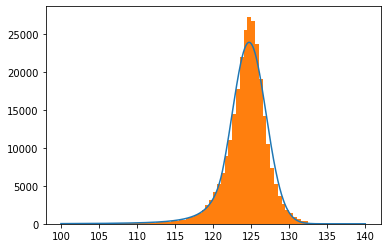

In [103]:
plot_scaling = len(arr_vtx0_ebee['mass'])/80*obs.area().numpy()
#plot_scaling = obs.area() / data_vtx0_ebee.n_events.numpy()
norm = data_vtx0_ebee.n_events.numpy()
fig, ax = plt.subplots()
x = np.linspace(100, 140, 1000)
mu.set_value(result_0.params[mu]["value"])
sigma.set_value(result_0.params[sigma]["value"])
#sigma.set_value(2.5)
n.set_value(result_0.params[n]["value"])
alpha.set_value(result_0.params[alpha]["value"])
y = cb.pdf(x, norm_range=obs).numpy()
plt.plot(x, y*plot_scaling, label="Model")
#plt.plot(x, y*norm, label="Model")
#hist.plot1d(histo_ebee["Vertex 0th"], density=False)
plt.hist(arr_vtx0_ebee['mass'], 80, (100, 140))
plt.show();

<BarContainer object of 80 artists>

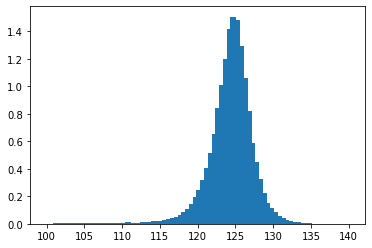

In [85]:
histo_ebee.values()[('Vertex 0th',)]

plt.bar(bincenters, histo_ebee.values()[('Vertex 0th',)])

In [70]:
bins = histo_ebee.axis('mass').edges()

In [71]:
bincenters = 0.5*(bins[1:]+bins[:-1])

In [73]:
len(bincenters)

80

In [123]:
y = cb.pdf(bincenters, norm_range=obs).numpy()

In [101]:
len(arr_vtx0_ebee['mass'])/80*obs.area().numpy()

array([140212.5])

In [23]:
from scipy.stats import chisquare

In [70]:
# Goodness of fit 
n_bins = 20
mask = (arr_vtx0_ebee.mass > 120) & (arr_vtx0_ebee.mass < 130)
obs_values, obs_edges = np.histogram(arr_vtx0_ebee[mask]['mass'].to_numpy(), n_bins, fit_range, weights=arr_vtx0_ebee[mask]['weight'].to_numpy(), density=True)
#obs_values, obs_edges = np.histogram(arr_vtx0_ebee[mask]['mass'].to_numpy(), n_bins, fit_range, density=True)
obs_centers = .5*(obs_edges[1:] + obs_edges[:-1]) 
plot_scaling = len(arr_vtx0_ebee['mass'])/n_bins*obs.area().numpy()

#exp_values = cb.pdf(obs_centers).numpy() * plot_scaling
exp_values = cb.pdf(obs_centers).numpy()

#res = chisquare()

In [71]:
obs_values

array([0.0335713 , 0.04313045, 0.05553987, 0.0700332 , 0.08900361,
       0.11555681, 0.1378346 , 0.16433401, 0.1941946 , 0.20612001,
       0.20253027, 0.17666277, 0.14525605, 0.11253176, 0.08054692,
       0.0616303 , 0.04428669, 0.03058659, 0.02097366, 0.01567647])

In [72]:
exp_values

array([0.03246295, 0.04088189, 0.05206149, 0.06711773, 0.08771307,
       0.11587098, 0.1461369 , 0.17279651, 0.19155784, 0.19909245,
       0.19399902, 0.17722875, 0.15179543, 0.12189141, 0.09176507,
       0.06476965, 0.04286034, 0.02659069, 0.01546655, 0.00843426])

In [73]:
r, p = chisquare(obs_values, exp_values)

In [74]:
r

0.013439287724610779

In [75]:
p

1.0